# Coronavirus tweets NLP - Text Classification
### Corona Virus Tagged Data

**Task**  
Perform Text Classification on the tweets pulled from Twitter.

**Columns:**
- Location  
- Tweet At  
- Original Tweet  
- Label  

**Models**  
I used a baseline Naive Bayes model and a Neural Network archiecture using DistilBERT as the embedding layer with a LSTM and Dense layers following. I used huggingface's transformers library and tensorflow for the deep learning model and scikit-learn for the naive bayes model. I also used GPU acceleration through a GTX 1060 (6GB) for training the neural network. 

**Link to data:**  
https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

<hr>

**Imports**

In [3]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Progress Bar
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import warnings
from transformers import logging as hf_logging
hf_logging.set_verbosity_error() # Hidding Huggingface Warnings
warnings.filterwarnings("ignore")

Enabling GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
plt.style.use('ggplot')

**DistilBERT Model**

https://huggingface.co/distilbert-base-uncased

In [5]:
MODEL_NAME = 'distilbert-base-cased'

### Loading Data

In [6]:
test_df = pd.read_csv('./Corona_NLP_test.csv', encoding = "UTF-8", encoding_errors='ignore')
train_df = pd.read_csv('./Corona_NLP_train.csv', encoding = "UTF-8", encoding_errors='ignore')

*Dropping any duplicates or missing values*

In [7]:
train_df.drop_duplicates(inplace= True)
test_df.drop_duplicates(inplace=True)

In [8]:
train_df.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [9]:
test_df.isna().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

Because a missing location is not as important as a missing tweet or sentiment, I will not remove those entires.

In [10]:
print(f"There are {train_df.shape[0]} entries in the training dataframe")
train_df.head()

There are 41157 entries in the training dataframe


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [11]:
print(f"There are {test_df.shape[0]} entries in the test dataframe")
test_df.head()

There are 3798 entries in the test dataframe


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


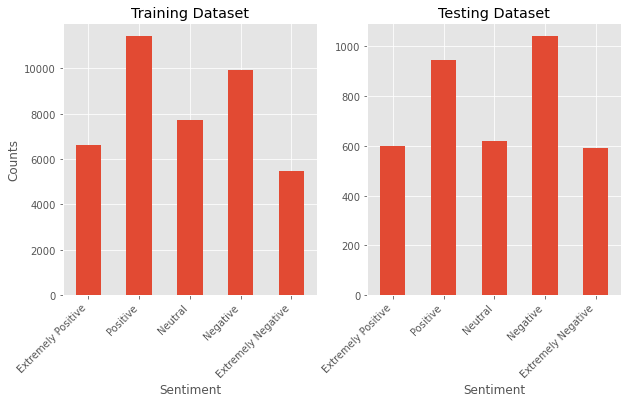

In [12]:
reorder = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']

fig, axes = plt.subplots(1,2 , figsize=(10,5))

train_df.value_counts('Sentiment').reindex(index=reorder).plot(kind='bar', ax=axes[0])
plt.sca(axes[0])
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Training Dataset')
plt.ylabel('Counts')

test_df.value_counts('Sentiment').reindex(index=reorder).plot(kind='bar', ax=axes[1])
plt.sca(axes[1])
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Testing Dataset');

It looks like the training and testsing datasets are not balanced across all categories.

In [13]:
max_words = []
for row in train_df['OriginalTweet']:
    max_words.append(len(row.split()))
print(f"The max word count is {np.asarray(max_words).max()}")

The max word count is 64


**Getting rid of the URL's in the tweets**

In [14]:
test_str = test_df['OriginalTweet'][0]
print(test_str)

def remove_https(row):
    return re.sub(r'http\S+', '', row)

remove_https(test_str)

TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1


'TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up  '

*Apply to whole datasets*

In [15]:
train_df['OriginalTweet_no_URL'] = train_df['OriginalTweet'].apply(remove_https)
test_df['OriginalTweet_no_URL'] = test_df['OriginalTweet'].apply(remove_https)

**Label Encode the datasets**

In [16]:
le = LabelEncoder()
train_df['Sentiment_label'] = le.fit_transform(train_df['Sentiment'])
test_df['Sentiment_label'] = le.transform(test_df['Sentiment'])

In [17]:
label_dict = (test_df[['Sentiment','Sentiment_label']].drop_duplicates()
              .sort_values(by='Sentiment_label')
              .reset_index(drop=True)['Sentiment']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 Extremely Negative
1 Extremely Positive
2 Negative
3 Neutral
4 Positive


**Splitting the data**

I will take 10% of the training data as validation data

In [18]:
# Get the number training samples
num_train_samples = int(train_df.shape[0] * 0.9)

x_train = train_df['OriginalTweet_no_URL'][:num_train_samples]
y_train = train_df['Sentiment_label'][:num_train_samples]
x_val = train_df['OriginalTweet_no_URL'][num_train_samples:]
y_val = train_df['Sentiment_label'][num_train_samples:]

### Sanity Check
assert(len(x_train) + len(x_val) == train_df.shape[0])

print(f"{len(x_train)} training examples\n{len(x_val)} validation examples")

37041 training examples
4116 validation examples


In [19]:
x_test = test_df['OriginalTweet_no_URL']
y_test = test_df['Sentiment_label']
print(f"{len(x_test)} testing examples")

3798 testing examples


## Naive Bayes (Baseline Model)

Pre-processing by:  
- remove punctuations (except #)
- lowercase all words
- removing stopwords
- stemming words

*Note: I will not remove the **#** symbol because it is a predominant part of what makes tweets unique*

In [20]:
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

# Remove all puncutation
def clean_responses(text):
    ### Remove all puncutation
    string.punctuation = string.punctuation.replace('#','')
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    
    ### Lowercase
    text = text.lower()
    
    ### Removing stop words
    filtered_words = []
    for word in text.split():
        if word not in stop_words:
            filtered_words.append(word)
            
    ### Stemming words
    stemmed = [porter.stem(word) for word in filtered_words]
                
    return ' '.join(stemmed)

In [21]:
X_train_NB = train_df['OriginalTweet_no_URL'].apply(clean_responses)
y_train_NB = train_df['Sentiment_label']
X_test_NB = test_df['OriginalTweet_no_URL'].apply(clean_responses)
y_test_NB = test_df['Sentiment_label']

In [22]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train_NB, y_train_NB)

### Make predictions
y_hat = model.predict(X_test_NB)

**Results**

Accuracy: 0.3451816745655608


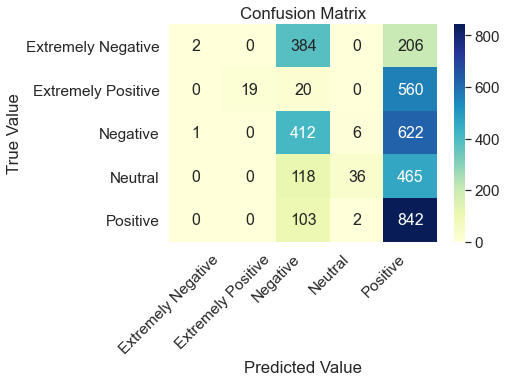

In [23]:
print("Accuracy:", accuracy_score(y_test_NB, y_hat))
labels_5 = ['Extremely Negative','Extremely Positive','Negative','Neutral','Positive'] 

def print_cf1(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame(cm, index=labels_5,columns=[0,1,2,3,4]), 
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2,3,4], labels_5, rotation=45)
    plt.ylabel("True Value")
    plt.show()
    
print_cf1(y_test_NB, y_hat)

In [24]:
print(classification_report(y_test_NB, y_hat, target_names=labels_5))

                    precision    recall  f1-score   support

Extremely Negative       0.67      0.00      0.01       592
Extremely Positive       1.00      0.03      0.06       599
          Negative       0.40      0.40      0.40      1041
           Neutral       0.82      0.06      0.11       619
          Positive       0.31      0.89      0.46       947

          accuracy                           0.35      3798
         macro avg       0.64      0.28      0.21      3798
      weighted avg       0.58      0.35      0.25      3798



## DistilBERT

**Tokenize the Inputs** 

In [25]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME) # Loading the tokenizer

*Finding the max token sequence in the training set*

In [26]:
max_val = 0
for sent in (x_train.tolist() + x_train.tolist() + x_val.tolist()):
    try:
        sent_tok_len = len(tokenizer.tokenize(sent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_val}")

The maximum amount of tokens in the dataset is 232


I will set the max length and input for the deep learning model to 234  
*(Max token length + 2 for special characters [CLS] and [SEP])*

In [39]:
MAX_LENGTH = 234

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH, 
                                                pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LENGTH, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [40]:
X_train = tokenize(x_train, tokenizer)
X_test = tokenize(x_test, tokenizer)
X_val = tokenize(x_val, tokenizer)

100%|████████████████████████████████████████████████████████████████████████████| 4116/4116 [00:03<00:00, 1285.07it/s]


**Looking at entry**

In [29]:
index_num = 5

print(train_df.loc[index_num]['Sentiment'], '\n')

print(x_train[index_num], '\n')

temp_tokens = tokenizer.tokenize(x_train[index_num])
temp_ids = tokenizer.encode(x_train[index_num])

print('ID\'s', 'Input Tokens', sep='\t')
for i in range(len(temp_ids)):
    if i == 0:
        print(temp_ids[i], '[CLS]', sep='\t')
        continue
    if i == len(temp_ids)-1:
        print(temp_ids[i], '[SEP]', sep='\t')
        break
    print(temp_ids[i], temp_tokens[i-1], sep='\t')

Positive 

As news of the regions first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports  

ID's	Input Tokens
101	[CLS]
1249	As
2371	news
1104	of
1103	the
4001	regions
1148	first
3659	confirmed
18732	CO
23314	##VI
2137	##D
118	-
1627	19
1692	case
1338	came
1149	out
1104	of
7124	Sullivan
1391	County
1314	last
1989	week
117	,
1234	people
24117	flock
1174	##ed
1106	to
1298	area
4822	stores
1106	to
4779	purchase
9374	cleaning
5508	supplies
117	,
1289	hand
21718	sa
2605	##ni
3121	##ti
6198	##zer
117	,
2094	food
117	,
12356	toilet
2526	paper
1105	and
1168	other
4817	goods
117	,
137	@
4446	Tim
168	_
2091	Do
21369	##dson
3756	reports
102	[SEP]


### Creating the model

In [33]:
config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(5, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 234)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 234)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_1 (TFDisti TFBaseModelOutput(la 65190912    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 234, 256)     918528      tf_distil_bert_model_1[0][1

*Creating a output directory to store the models weights*

In [34]:
### Create an output directory
output_dir = './model1_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

*Callbacks*

In [35]:
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

early_stopping = EarlyStopping(patience=3, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

**Compile and train**

In [42]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    epochs = 10,
                    batch_size=16, 
                    validation_data=(X_val, y_val), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/10
2316/2316 [==============================] - 588s 250ms/step - loss: 1.3570 - accuracy: 0.4026 - val_loss: 1.0693 - val_accuracy: 0.5474
Epoch 2/10
2316/2316 [==============================] - 576s 249ms/step - loss: 1.0445 - accuracy: 0.5642 - val_loss: 0.9584 - val_accuracy: 0.6178
Epoch 3/10
2316/2316 [==============================] - 574s 248ms/step - loss: 0.9503 - accuracy: 0.6111 - val_loss: 0.9372 - val_accuracy: 0.6110
Epoch 4/10
2316/2316 [==============================] - 575s 248ms/step - loss: 0.8734 - accuracy: 0.6451 - val_loss: 0.9340 - val_accuracy: 0.6370

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/10
2316/2316 [==============================] - 574s 248ms/step - loss: 0.7637 - accuracy: 0.6975 - val_loss: 0.8732 - val_accuracy: 0.6579
Epoch 6/10
2316/2316 [==============================] - 577s 249ms/step - loss: 0.7168 - accuracy: 0.7183 - val_loss: 0.8726 - val_accuracy: 0.6545

Epoch 00006: ReduceLROnPlatea

Plotting the training accuracy and loss

Lowest Validation Loss: epoch 6
Highest Validation Accuracy: epoch 5


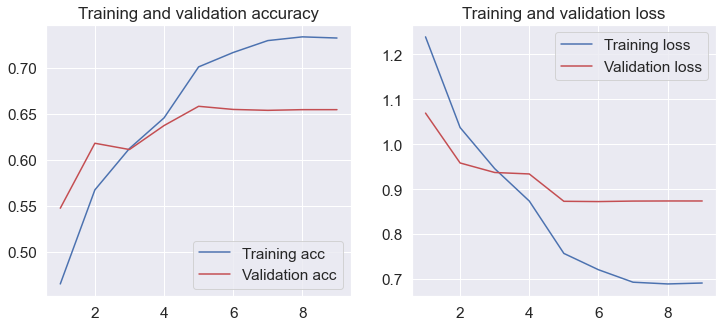

In [43]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(history)

Loading the model with the best validation accuracy

In [44]:
def get_min_val_loss_epoch(history):
    return "0"+str(np.argmin(history.history['val_loss'])+1)

def get_max_val_acc_epoch(history):
    return "0"+str(np.argmax(history.history['val_accuracy'])+1)

In [45]:
epoch_num = get_max_val_acc_epoch(history)
model.load_weights(output_dir+"/weights."+epoch_num+".hdf5") # Load in model weights

**Making inference on the test data**

In [46]:
y_test_probs = model.predict(X_test)

# Turn probabilities into an interger prediction
y_hat = []
for prob in y_test_probs:
    y_hat.append(np.argmax(prob))

**Results**

Accuracy: 0.6463928383359663


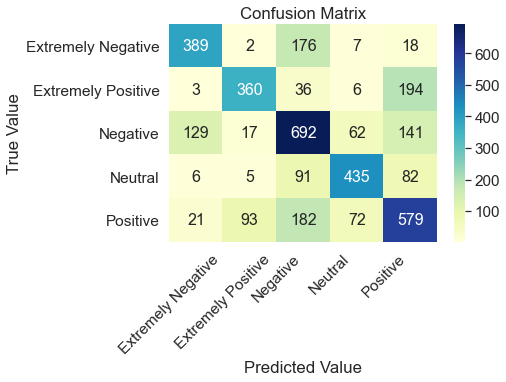

In [47]:
print("Accuracy:", accuracy_score(y_test, y_hat))
print_cf1(y_test, y_hat)

In [48]:
print(classification_report(y_test, y_hat, target_names=labels_5))

                    precision    recall  f1-score   support

Extremely Negative       0.71      0.66      0.68       592
Extremely Positive       0.75      0.60      0.67       599
          Negative       0.59      0.66      0.62      1041
           Neutral       0.75      0.70      0.72       619
          Positive       0.57      0.61      0.59       947

          accuracy                           0.65      3798
         macro avg       0.67      0.65      0.66      3798
      weighted avg       0.66      0.65      0.65      3798



## Combining Labels and Re-Running

In [49]:
def combining_labels(row):
    if row in 'Extremely Positive':        
        return 'Positive' 
    if row in 'Extremely Negative':
        return 'Negative'
    return row

### Combining Labels
train_df['Simple_Sentiment'] = train_df['Sentiment'].apply(combining_labels)
test_df['Simple_Sentiment'] = test_df['Sentiment'].apply(combining_labels)

### Encoding the labels
le = LabelEncoder()
train_df['Simple_Sentiment_label'] = le.fit_transform(train_df['Simple_Sentiment'])
test_df['Simple_Sentiment_label'] = le.transform(test_df['Simple_Sentiment'])

label_dict = (test_df[['Simple_Sentiment','Simple_Sentiment_label']].drop_duplicates()
              .sort_values(by='Simple_Sentiment_label')
              .reset_index(drop=True)['Simple_Sentiment']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 Negative
1 Neutral
2 Positive


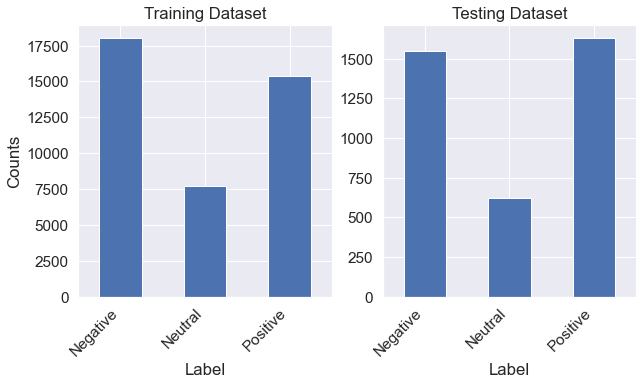

In [50]:
reorder_labels = [2,1,0]
reorder = ['Positive', 'Neutral', 'Negative']

fig, axes = plt.subplots(1,2 , figsize=(10,5))

train_df.value_counts('Simple_Sentiment_label').reindex(index=reorder_labels).plot(kind='bar', ax=axes[0])
plt.sca(axes[0])
plt.xticks(reorder_labels, reorder, rotation=45, horizontalalignment='right')
plt.title('Training Dataset')
plt.ylabel('Counts')
plt.xlabel('Label')

test_df.value_counts('Simple_Sentiment_label').reindex(index=reorder_labels).plot(kind='bar', ax=axes[1])
plt.sca(axes[1])
plt.xticks(reorder_labels, reorder, rotation=45, horizontalalignment='right')
plt.title('Testing Dataset')
plt.xlabel('Label');

Splitting datasets

In [51]:
### Only need to modify the labels
y_train = train_df['Simple_Sentiment_label'][:num_train_samples]
y_val = train_df['Simple_Sentiment_label'][num_train_samples:]
y_test = test_df['Simple_Sentiment_label']

print(f"{len(y_train)} training examples\n{len(y_val)} validation examples")
print(f"{len(y_test)} testing examples")

37041 training examples
4116 validation examples
3798 testing examples


### Naive Bayes (Baseline)

In [52]:
y_train_NB = train_df['Simple_Sentiment_label']
y_test_NB = test_df['Simple_Sentiment_label']

In [53]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train_NB, y_train_NB)

### Make predictions
y_hat = model.predict(X_test_NB)

**Results**

Accuracy: 0.6313849394418115


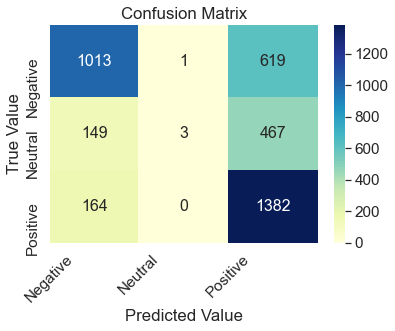

In [54]:
print("Accuracy:", accuracy_score(y_test_NB, y_hat))
labels_3 = ['Negative','Neutral','Positive'] 

def print_cf2(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame(cm, index=labels_3,columns=[0,1,2]), 
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2], labels_3, rotation=45)
    plt.ylabel("True Value")
    plt.show()
    
print_cf2(y_test_NB, y_hat)

In [55]:
print(classification_report(y_test_NB, y_hat, target_names=labels_3))

              precision    recall  f1-score   support

    Negative       0.76      0.62      0.68      1633
     Neutral       0.75      0.00      0.01       619
    Positive       0.56      0.89      0.69      1546

    accuracy                           0.63      3798
   macro avg       0.69      0.51      0.46      3798
weighted avg       0.68      0.63      0.58      3798



Our baseline to beat is **63% accuracy** in our predictions

## DistilBERT

### Creating the model

In [56]:
config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True, return_dict=True)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
attention_mask_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = attention_mask_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(3, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, attention_mask_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 234)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 234)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_2 (TFDisti TFBaseModelOutput(la 65190912    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 234, 256)     918528      tf_distil_bert_model_2[0][1

*Creating a new output director to store the models weights*

In [57]:
### Create an output directory
output_dir = './model2_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

**Compile and train**

In [58]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    epochs = 10,
                    batch_size=16, 
                    validation_data=(X_val, y_val), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/10
2316/2316 [==============================] - 584s 249ms/step - loss: 0.8404 - accuracy: 0.6146 - val_loss: 0.6429 - val_accuracy: 0.7257
Epoch 2/10
2316/2316 [==============================] - 573s 247ms/step - loss: 0.6204 - accuracy: 0.7489 - val_loss: 0.5740 - val_accuracy: 0.7672
Epoch 3/10
2316/2316 [==============================] - 573s 248ms/step - loss: 0.5433 - accuracy: 0.7871 - val_loss: 0.5487 - val_accuracy: 0.7845
Epoch 4/10
2316/2316 [==============================] - 572s 247ms/step - loss: 0.4776 - accuracy: 0.8140 - val_loss: 0.5372 - val_accuracy: 0.7884
Epoch 5/10
2316/2316 [==============================] - 562s 243ms/step - loss: 0.4314 - accuracy: 0.8370 - val_loss: 0.5380 - val_accuracy: 0.7886

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/10
2316/2316 [==============================] - 560s 242ms/step - loss: 0.3564 - accuracy: 0.8704 - val_loss: 0.5517 - val_accuracy: 0.7952

Epoch 00006: ReduceLROnPlatea

Plotting the training accuracy and loss

Lowest Validation Loss: epoch 4
Highest Validation Accuracy: epoch 6


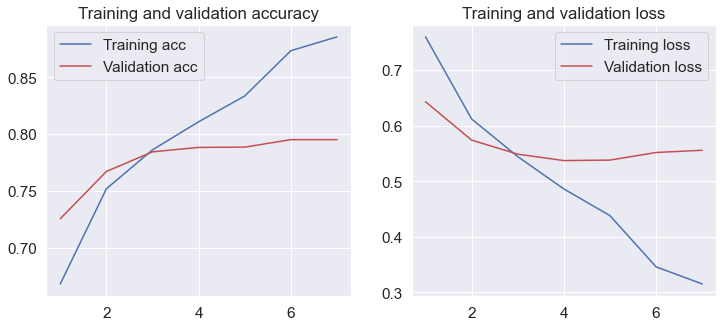

In [59]:
plot_history(history)

Loading the model weights with the best validation accuracy

In [60]:
epoch_num = get_max_val_acc_epoch(history)
model.load_weights(output_dir+"/weights."+epoch_num+".hdf5") # Load in model weights

**Making Inference**

In [61]:
y_test_probs = model.predict(X_test)

# Turn probabilities into an interger prediction
y_hat = []
for prob in y_test_probs:
    y_hat.append(np.argmax(prob))

**Results**

Accuracy: 0.7933122696155871


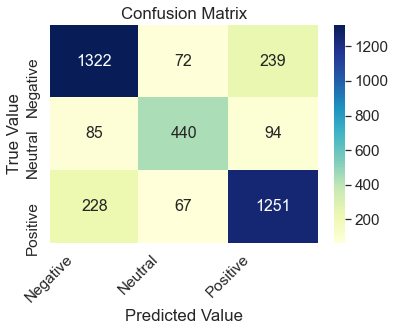

In [62]:
print("Accuracy:", accuracy_score(y_test, y_hat))
print_cf2(y_test, y_hat)

In [63]:
print(classification_report(y_test, y_hat, target_names=labels_3))

              precision    recall  f1-score   support

    Negative       0.81      0.81      0.81      1633
     Neutral       0.76      0.71      0.73       619
    Positive       0.79      0.81      0.80      1546

    accuracy                           0.79      3798
   macro avg       0.79      0.78      0.78      3798
weighted avg       0.79      0.79      0.79      3798



### Looking at which tweets we guessed incorrectly 

Observations that were predicted **Negative** (y_hat = 0) but actually **Positive** (y_test = 2)

*Printing the first 5 examples*

In [75]:
[print(example, '\n') for example in x_test[(y_test == 2) & (np.asarray(y_hat) == 0)][:5]];



Same with any other Bussiness. 

IMPORTANT UPDATE! Our CEO Brian Beaulieu has broadened the scope of his COVID-19 webinar. Expect more on the oil prices drop, stock market developments, retail sales, and unfolding situations in China and Italy. Learn more and register:   

Solid advice for seniors, their family members &amp; those of who have #complexhealth care needs.@CDC: Older #Americans should consider stocking up on food, medications &amp; avoid venturing out as #coronavirus spreads  #COVID19Canada #CoronavirusCanada #bcseniors 





Better than toilet rolls ?  

How the fuck am I safer from #coronavirus on a train or at a gas station or at a grocery store or gym than at #sxsw or a ballgame or a amusement park? Either put guys with gas masks and guns on the streets or let us live our lives 



Observations that were predicted **Positive** (y_hat = 2) but actually **Negative** (y_test = 0)

*Printing the first 5 examples*

In [76]:
[print(example, '\n') for example in x_test[(y_test == 0) & (np.asarray(y_hat) == 2)][:5]];









@HardeepSPuri @MoCA_GoI 







How Costco is Ha  











#Qanon #coronavirus  

Fellow Uni instructors! COVID-19 f2f class cancelations are  inconvenient! But remember you're salaried employees. Maybe call/email HR or your union &amp; demand to know how hourly workers (clerical, food-service, custodial, etc) will be  compensated during campus closures? 

1/25 Part 1 - Why does soap work so well on the SARS-CoV-2, the coronavirus and indeed most viruses? Because it is a self-assembled nanoparticle in which the weakest link is the lipid (fatty) bilayer. A two part thread about soap, viruses and supramolecular chemistry #COVID19  

